# This is the same notebook as the m2_ensemble_merging_v2.ipynb with the difference that here the purpose is to lock in the tuned fusion settings (trust weights + normalization) without overwriting the original notebook.

In [20]:
from pathlib import Path
from typing import Any, Dict, List, Tuple
from dataclasses import dataclass

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

from ml_carbucks import DATA_DIR
from ml_carbucks.adapters.EfficientDetAdapter import EfficientDetAdapter
from ml_carbucks.adapters.FasterRcnnAdapter import FasterRcnnAdapter
from ml_carbucks.adapters.UltralyticsAdapter import RtdetrUltralyticsAdapter, YoloUltralyticsAdapter
from ml_carbucks.utils.logger import setup_logger
from ml_carbucks.utils.preprocessing import create_clean_loader
from ml_carbucks.utils.postprocessing import postprocess_evaluation_results
from ml_carbucks.adapters.BaseDetectionAdapter import BaseDetectionAdapter

logger = setup_logger("adapter_fusion")


classes=["scratch", "dent", "crack"]

adapters=[
    YoloUltralyticsAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 32,
            "epochs": 27,
            "lr": 0.0015465639515144544,
            "momentum": 0.3628781599889685,
            "weight_decay": 0.0013127041660177367,
            "optimizer": "NAdam",
            "verbose": False,
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_YoloUltralyticsAdaptermodel.pt",
    ),
    RtdetrUltralyticsAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 16,
            "epochs": 10,
            "lr": 0.0001141043015859849,
            "momentum": 0.424704619626319,
            "weight_decay": 0.00012292547851740234,
            "optimizer": "AdamW",
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_RtdetrUltralyticsAdaptermodel.pt",
    ),
    # FasterRcnnAdapter is being skipped for this ensemble because its performance
    # is less than that of the other two adapters.
    
    EfficientDetAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 8,
            "epochs": 26,
            "optimizer": "momentum",
            "lr": 0.003459928723120903,
            "weight_decay": 0.0001302610542371722,
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_EfficientDetAdaptermodel.pth",
    ),
]

train_datasets = [
    (
        DATA_DIR / "car_dd" / "images" / "train",
        DATA_DIR / "car_dd"/ "annotations" / "instances_train_curated.json",
    )
]

val_datasets: List[Tuple[str | Path, str | Path]] = [
    (
        DATA_DIR / "car_dd"/"images" / "val",
        DATA_DIR / "car_dd"/ "annotations"/ "instances_val_curated.json",
    )
]

## Collect cached adapter predictions for debugging
We now just call `EnsembleModel.predict_from_datasets(...)` to gather per‑adapter predictions and ground truths for later analysis (no manual loops needed).

In [21]:
from ml_carbucks.ensemble.EnsembleModel import EnsembleModel

ensemble_model = EnsembleModel(
    classes=classes,
    adapters=adapters,
    fusion_strategy="nms",         # or "wbf"
    fusion_conf_threshold=0.25,
    fusion_iou_threshold=0.55,
    fusion_max_detections=300, 
    loader_batch_size=8,
    #fusion_apply_normalization=True, 
    fusion_norm_method="minmax",
    fusion_trust_weights=[0.2, 0.7, 0.1], # The tuned trust weights from m4_trust_weight_tuning
    # NOTE: i dont know why but the weight return the map50-95 less than without weights
).setup()

per_adapter_metrics = ensemble_model.evaluate_adapters_by_predict_from_dataset(val_datasets)

print("Per Adapter Metrics: ", per_adapter_metrics)

adap_preds, gts, per_adapter_preds = ensemble_model.predict_from_datasets(val_datasets)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
INFO ml_carbucks.ensemble.EnsembleModel 18:59:12 | Collecting adapter predictions...


Ensemble loader: 100%|██████████| 102/102 [00:22<00:00,  4.46it/s]

INFO ml_carbucks.ensemble.EnsembleModel 18:59:35 | Finished collecting adapter predictions.
INFO ml_carbucks.ensemble.EnsembleModel 18:59:35 | Evaluating adapter predictions: YoloUltralyticsAdapter


INFO ml_carbucks.ensemble.EnsembleModel 18:59:35 | YoloUltralyticsAdapter metrics -> map_50: 0.311 | map_75: 0.153 | map_50_95: 0.165
INFO ml_carbucks.ensemble.EnsembleModel 18:59:35 | Evaluating adapter predictions: RtdetrUltralyticsAdapter
INFO ml_carbucks.ensemble.EnsembleModel 18:59:35 | RtdetrUltralyticsAdapter metrics -> map_50: 0.449 | map_75: 0.243 | map_50_95: 0.251
INFO ml_carbucks.ensemble.EnsembleModel 18:59:35 | Evaluating adapter predictions: EfficientDetAdapter
INFO ml_carbucks.ensemble.EnsembleModel 18:59:35 | EfficientDetAdapter metrics -> map_50: 0.356 | map_75: 0.137 | map_50_95: 0.166
Per Adapter Metrics:  [{'map_50': 0.3114479184150696, 'map_50_95': 0.1649264544248581, 'map_75': 0.1527780294418335, 'classes': [1, 2, 3]}, {'map_50': 0.44884592294692993, 'map_50_95': 0.2507704794406891, 'map_75': 0.24307547509670258, 'classes': [1, 2, 3]}, {'map_50': 0.3560166358947754, 'map_50_95': 0.16611579060554504, 'map_75': 0.13654088973999023, 'classes': [1, 2, 3]}]
loading an

Ensemble loader: 100%|██████████| 102/102 [00:22<00:00,  4.46it/s]

INFO ml_carbucks.ensemble.EnsembleModel 18:59:58 | Finished collecting adapter predictions.


INFO ml_carbucks.ensemble.merging 18:59:58 | Applying NMS fusion strategy...


## Actual debugging and ensmble results comparison

In [22]:
fused_preds, gts, per_adapter_preds = ensemble_model.predict_from_datasets(
    val_datasets,
    strategy="nms",
    conf_threshold=0.25,
    iou_threshold=0.55,
)

metric = MeanAveragePrecision()
metric.update(fused_preds, gts)
postprocess_evaluation_results(metric.compute())


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
INFO ml_carbucks.ensemble.EnsembleModel 18:59:58 | Collecting adapter predictions...


Ensemble loader: 100%|██████████| 102/102 [00:22<00:00,  4.47it/s]

INFO ml_carbucks.ensemble.EnsembleModel 19:00:21 | Finished collecting adapter predictions.


INFO ml_carbucks.ensemble.merging 19:00:21 | Applying NMS fusion strategy...


{'map_50': 0.40788909792900085,
 'map_50_95': 0.2290259301662445,
 'map_75': 0.22435036301612854,
 'classes': [1, 2, 3]}

## Comparison

INFO adapter_fusion 19:00:22 | Randomly selecting 5 images, skipping 25
INFO adapter_fusion 19:00:22 | Displaying 5 images after skipping 25 images.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


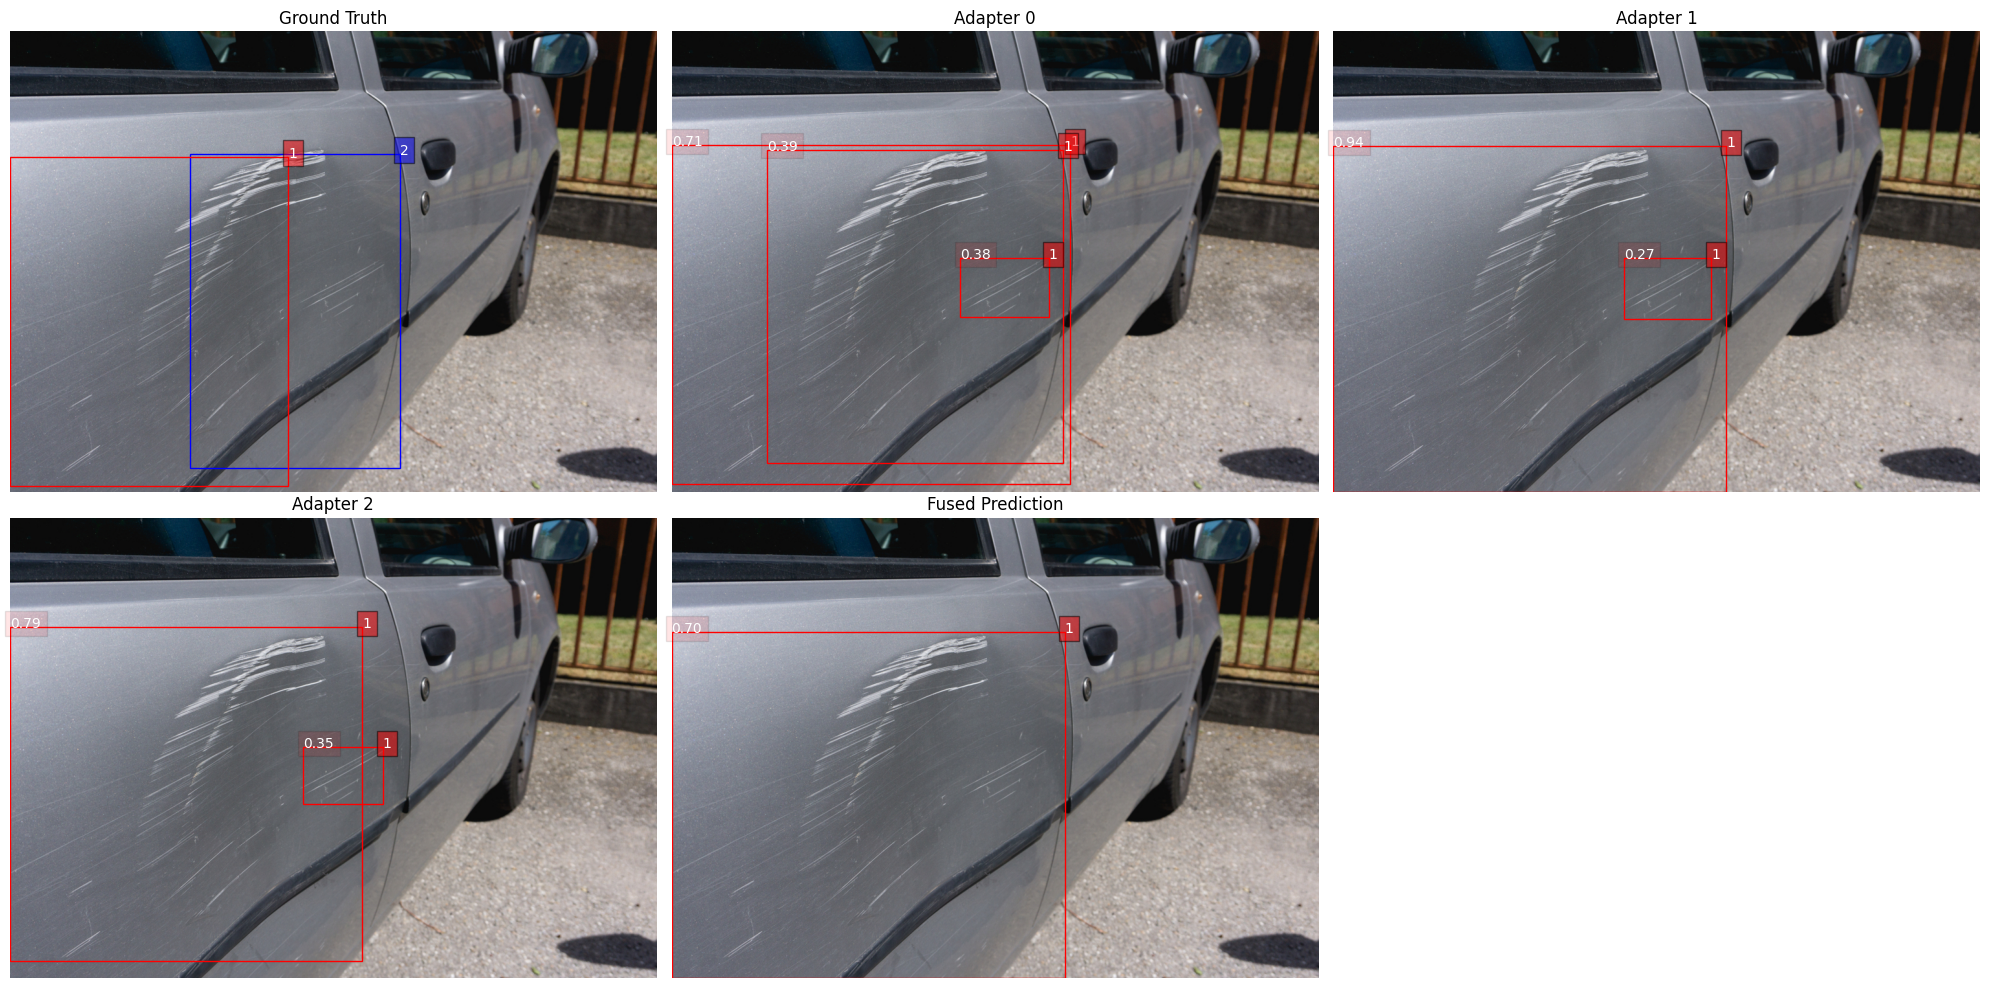

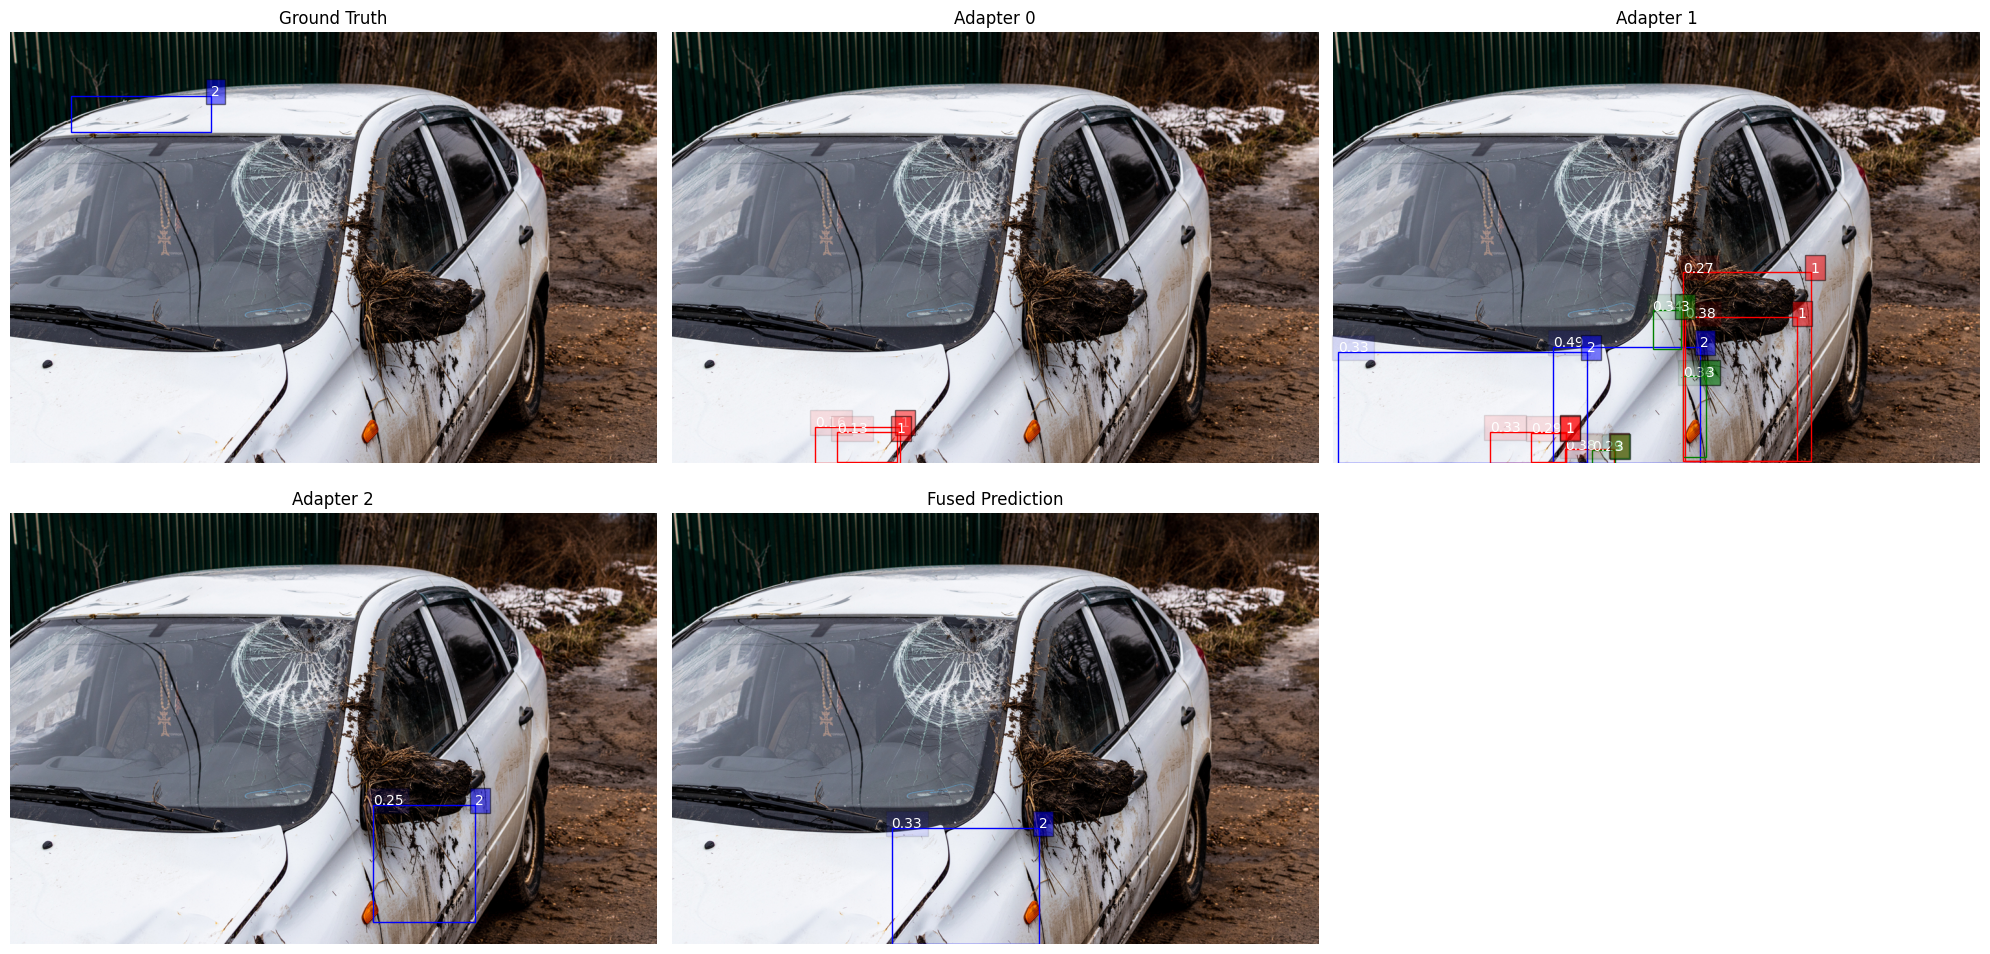

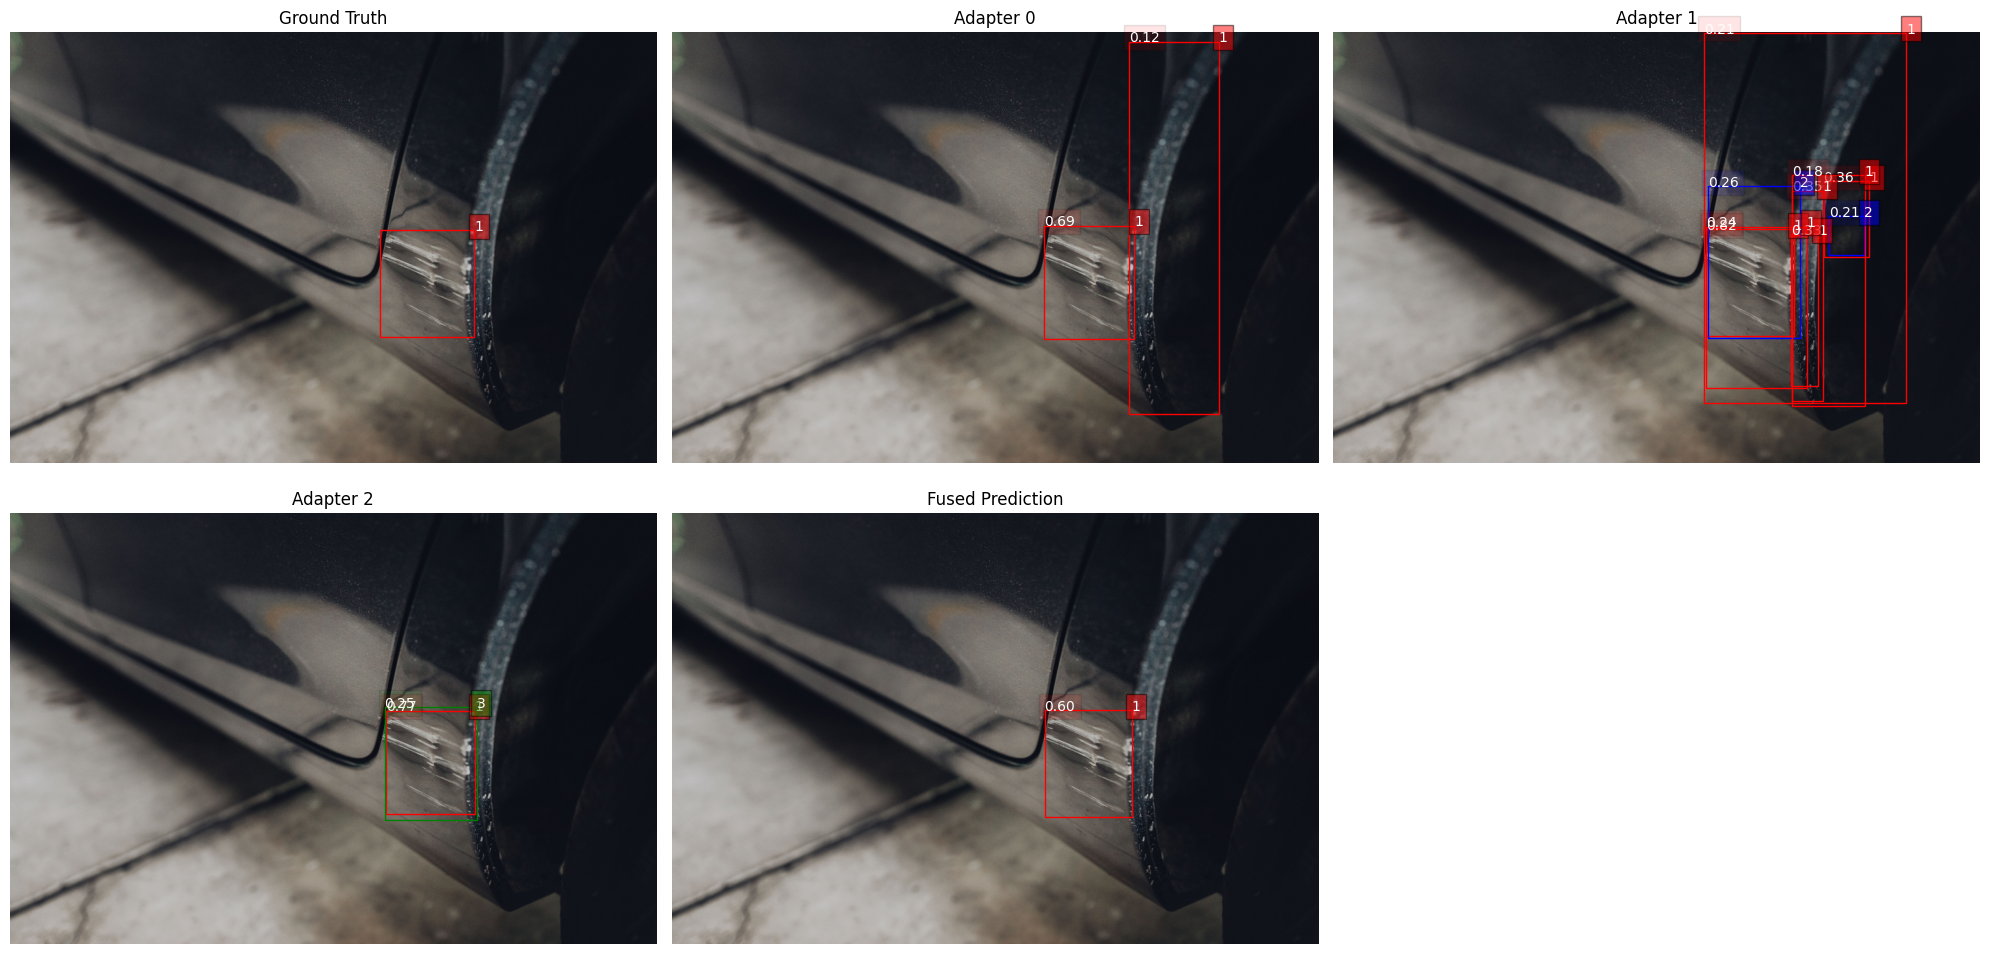

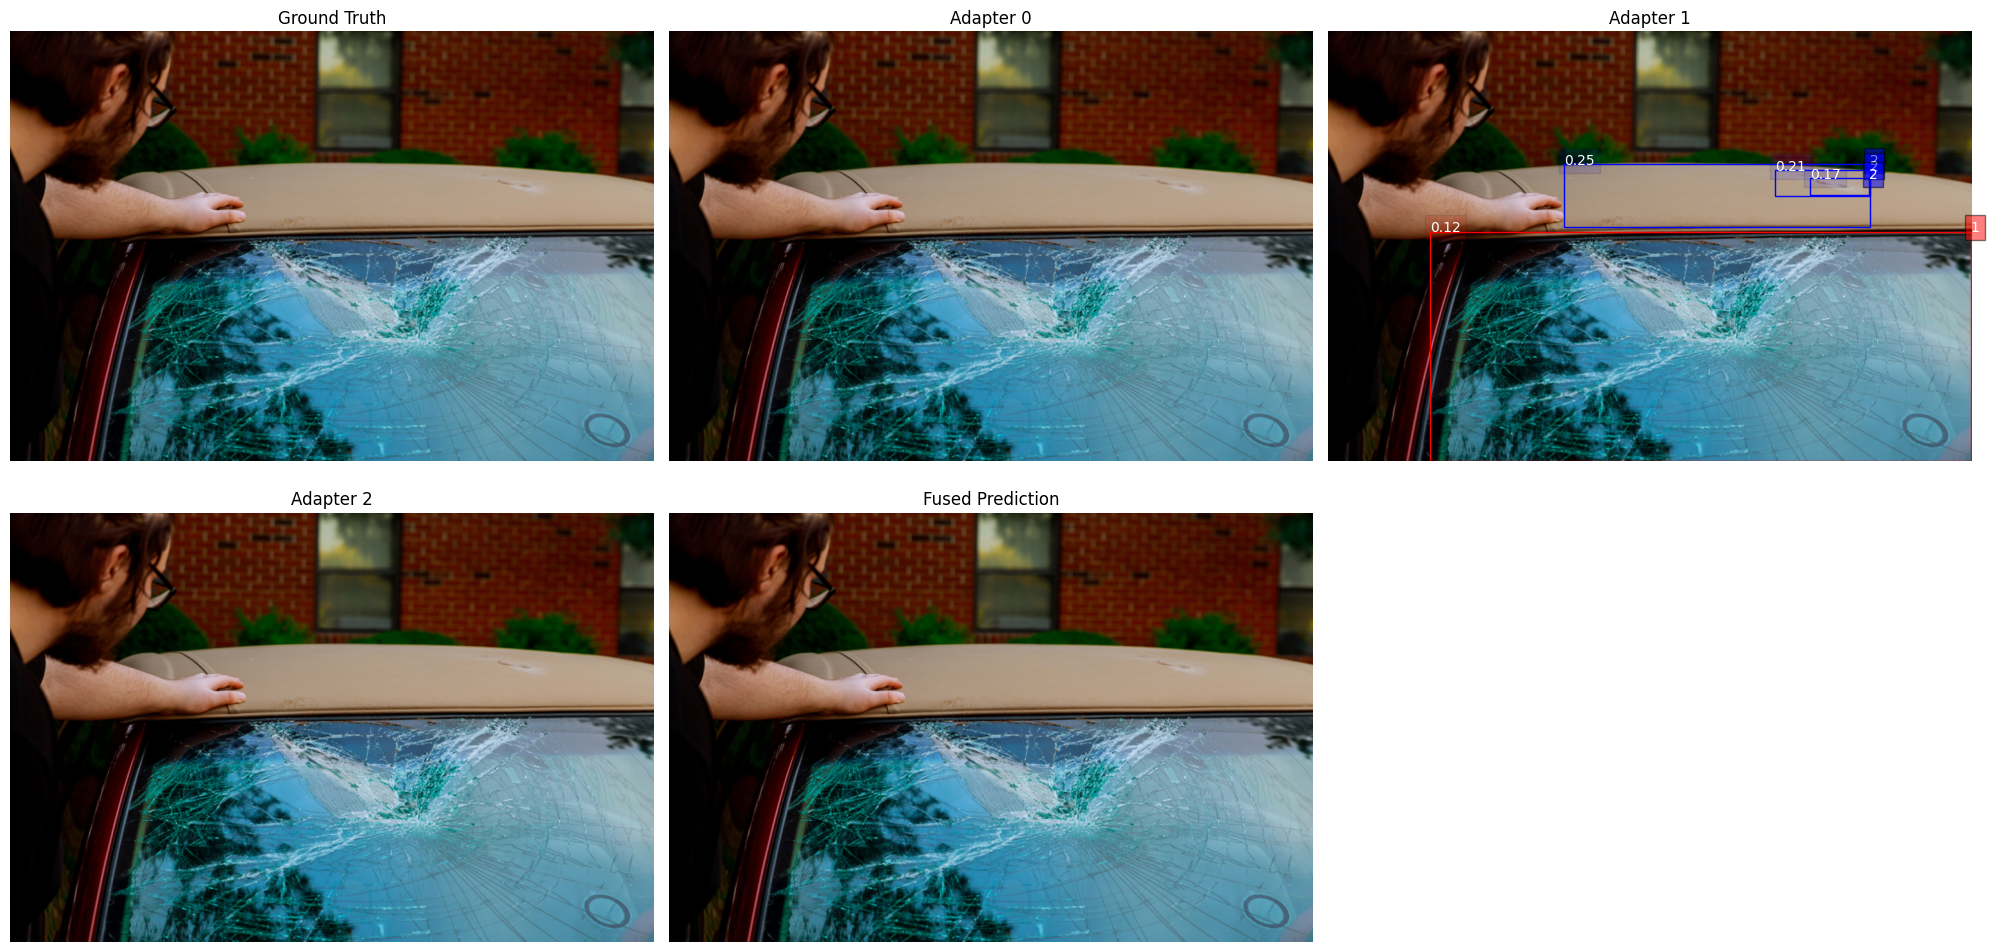

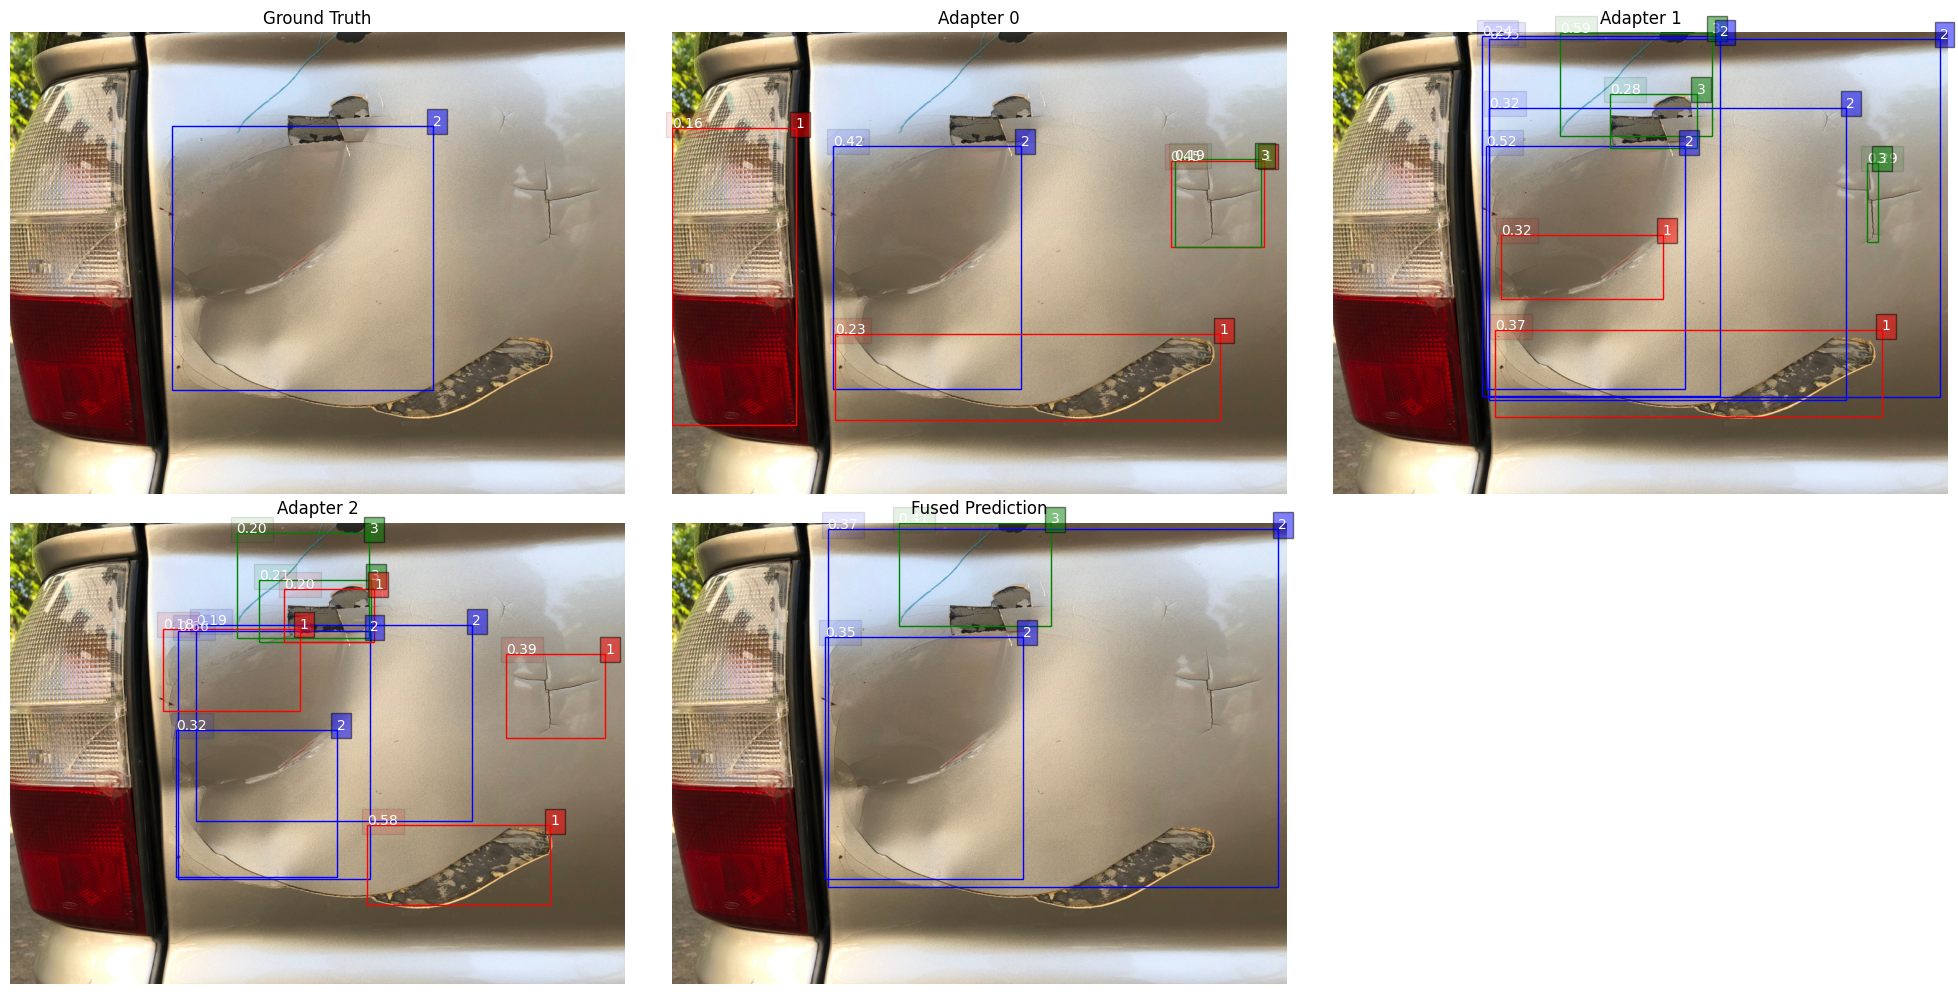

In [23]:
import random
import torch
from ml_carbucks.utils.inference import plot_img_pred_subplots as psp

def display_models(cnt, skip=0):
    """
    Build a loader and iterate over images, calling PSP with:
    - Ground truth
    - Per-adapter predictions  
    - Fused predictions
    """
    logger.info(f"Displaying {cnt} images after skipping {skip} images.")
    
    # Create clean loader just like before
    batch_size = 8
    loader = create_clean_loader(
        val_datasets, 
        shuffle=False, 
        transforms=None, 
        batch_size=batch_size
    )
    
    offset = -batch_size
    
    for images, targets in loader:
        offset += batch_size
        
        for i in range(len(images)): 
            if skip > 0:
                skip -= 1
                continue

            cnt -= 1
            if cnt < 0:
                break

            img = images[i]
            gt = targets[i]
            
            # Call PSP with [gt] + per-adapter + fused boxes/scores/labels
            psp(
                img_list=[torch.from_numpy(img).permute(2, 0, 1) for _ in range(len(per_adapter_preds) + 2)],
                bboxes_list=[
                    gt["boxes"],  # Ground truth
                    *[per_adapter_preds[adapter_idx][offset + i]["boxes"] for adapter_idx in range(len(per_adapter_preds))],  # Per-adapter predictions
                    fused_preds[offset + i]["boxes"],  # Fused prediction
                ],
                labels_list=[
                    gt["labels"],  # Ground truth
                    *[per_adapter_preds[adapter_idx][offset + i]["labels"] for adapter_idx in range(len(per_adapter_preds))],  # Per-adapter predictions
                    fused_preds[offset + i]["labels"],  # Fused prediction
                ],
                scores_list=[
                    None,  # Ground truth has no scores
                    *[per_adapter_preds[adapter_idx][offset + i]["scores"] for adapter_idx in range(len(per_adapter_preds))],  # Per-adapter predictions
                    fused_preds[offset + i]["scores"],  # Fused prediction
                ],
                descriptions=[
                    "Ground Truth",
                    *[f"Adapter {adapter_idx}" for adapter_idx in range(len(per_adapter_preds))],  # Per-adapter names
                    "Fused Prediction",
                ],
                coords="xyxy",
                figsize=(20, 10),
            )

        if cnt < 0:
            break

# Display some random images for comparison
cnt_random, skip_random = random.randint(2, 5), random.randint(0, 50)
logger.info(f"Randomly selecting {cnt_random} images, skipping {skip_random}")

display_models(cnt_random, skip_random)

## Results

Prediction scores of previous models were:
- xxxx
- xxxx
- xxxxx

Initial ensemble merging with NMS strategy resulted in:
- xxxxx

This demonstrates that ensemble merging can improve the performance over individual models. 
On this demo example it proved to improve the score by about `xxxx` over the best singular model.

## Discussion
The scores of singular models vary significantly, indicating that some models perform better than others. Regardless, the ensemble merging was still able to improve the overall performance.


The ensemble merging proved to be more effective, however it did not drastically outperform the best singular model.
It can be because the idea of the ensemble is that the models should correct their own small mistakes by each other. But if models make very different mistakes, then the ensemble merging may not be able to effectively combine their predictions.
In this case, the models had quite varying scores, indicating that they could have made very different types of errors.

Perhaps this is why the WBF strategy did not perform as well as NMS in this case, since WBF relies on the assumption that models make similar predictions with small variations.

Initial experiments suggest that it could be beneficial to select models that have similar performance levels for ensemble merging, as they may have more complementary strengths and weaknesses.

## Conclusions
The ensemble merging technique, particularly NMS, showed to be effective in improving model performance. 
Future work could explore more sophisticated ensemble methods or investigate the impact of model diversity on ensemble effectiveness.
